# Calibrate

Either copy camera transformations from another location or perform calibration here

In [9]:
PARAMS = {
    'session_name':'calibration',
    'working_directory':'long_pairs',
    'copy_transforms_from_other_directory':'',
    'reference_camera':'739112060301',
    'multiprocessing':True,
    'batch_size': 100
}

In [5]:
import shutil, json, os, sys, time, pickle, h5py, cv2, numpy as np, matplotlib.pyplot as plt
from MoseqMulti_calibrate import *
from MoseqMulti_utils import *
%matplotlib inline

Calculating camera transforms
Processing frame 0 out of 2984 for camera 1
Processing frame 0 out of 2989 for camera 2
Processing frame 0 out of 2980 for camera 0
Processing frame 0 out of 2994 for camera 3
Processing frame 0 out of 3008 for camera 4
Processing frame 100 out of 2980 for camera 0
Processing frame 100 out of 2989 for camera 2
Processing frame 100 out of 3008 for camera 4
Processing frame 100 out of 2984 for camera 1
Processing frame 100 out of 2994 for camera 3
Processing frame 200 out of 2984 for camera 1
Processing frame 200 out of 2994 for camera 3
Processing frame 200 out of 3008 for camera 4
Processing frame 200 out of 2989 for camera 2
Processing frame 200 out of 2980 for camera 0
Processing frame 300 out of 2994 for camera 3
Processing frame 300 out of 2984 for camera 1
Processing frame 300 out of 2989 for camera 2
Processing frame 300 out of 3008 for camera 4
Processing frame 400 out of 2994 for camera 3
Processing frame 300 out of 2980 for camera 0
Processing fra

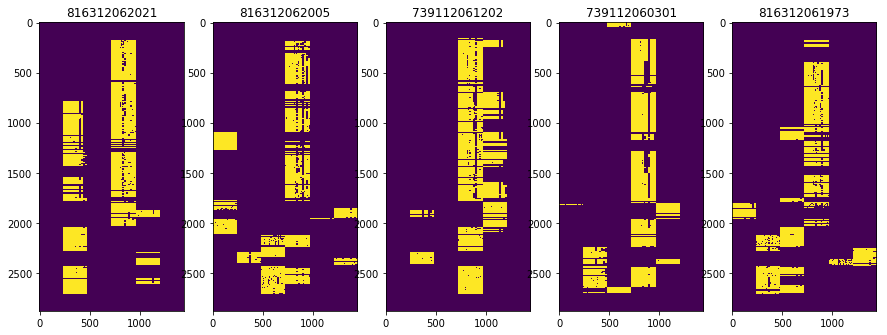

In [6]:
if len(PARAMS['copy_transforms_from_other_directory']) > 0:
    print('Copying camera transforms from '+ PARAMS['copy_transforms_from_other_directory'])
    os.system('cp '+PARAMS['copy_transforms_from_other_directory']+'/transforms.p '+PARAMS['working_directory']+'/') 
else:
    print('Calculating camera transforms')
    transforms = get_transforms(PARAMS)
    pickle.dump(transforms, open(PARAMS['working_directory']+'/transforms.p','wb'))

### ~~ This part is under construction ~~ ###

In [3]:
from pyntcloud import PyntCloud
import pandas as pd

n = 'two_mice_v2'
path_prefix = PARAMS['working_directory']+'/data/'+n
metadata = json.load(open(path_prefix+'_metadata.json'))
transforms = pickle.load(open(PARAMS['working_directory']+'/transforms.p','rb'))

In [15]:


serial_numbers = metadata['serial_numbers']

colors = []
positions = []
cam_labels = []
colorA,depthA = get_aligned_frameset(1000,PARAMS)
for ii,sn in enumerate(serial_numbers):
    color_im = colorA[sn]
    depth_im = depthA[sn]
        
    X,Y = np.meshgrid(np.arange(color_im.shape[1]),np.arange(color_im.shape[0]))
    pixel = np.vstack((X.flatten(),Y.flatten())).T
    depth = depth_im.flatten()
    ff = depth < 1000
    pp = deproject(pixel[ff,:],depth[ff], metadata['intrinsics'][sn])
    R,t = transforms[sn]
    pp = pp.dot(R.T) + t
    positions.append(pp)
    cc = color_im.reshape(color_im.shape[0]*color_im.shape[1],3)[ff,:]
    #cc = cc * .8
    #cc = np.minimum(cc +np.repeat(np.array(plt.cm.jet(ii/len(serial_numbers))[:3])[None,:]*60,cc.shape[0],axis=0),255)
    colors.append(cc)
    cam_labels.append(np.ones(pp.shape[0])*ii)
colors = np.vstack(colors)[:,::-1]
positions = np.vstack(positions)
cam_labels = np.hstack(cam_labels)

cube_centroid = positions.mean(0)
dist = np.sqrt(((positions-cube_centroid)**2).sum(1))
ff = dist < 550
positions = positions[ff,:]
colors = colors[ff] #,:]
cam_labels = cam_labels[ff]

positions[:,2] = -positions[:,2]
points = pd.DataFrame(
    positions.astype(np.float32), 
    columns=['x', 'y', 'z'])
points['red']=colors[:,0].astype(np.uint8)
points['blue']=colors[:,2].astype(np.uint8)
points['green']=colors[:,1].astype(np.uint8)

cloud = PyntCloud(points)
cloud.plot(initial_point_size=6)

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(28.352083206176758, 263.7600269317627, -362.…

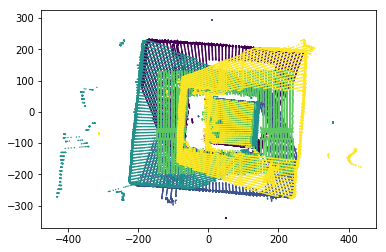

In [16]:
plt.scatter(positions[::10,0],positions[::10,1], s=2, edgecolor='', c=cam_labels[::10])